# Analyze E8 for DELL


Known VCPs for my DELL U4323QE:

- 60 (standard) primary source
- E7 (custom) KVM Switch Display to USB port assignment
  - write `xff00` to switch to the next screen next [^1]
- E8 (custom) secondary sources
- E9 (custom) PBP/PIP mode

The code below is meant to analyze E8. I think E9 is just enumerated, no idea if there's a rule. 60 is very easy to get manually - there are only 5 possibilities.

| Input | VCP 60 |
| ----- | ------ |
| USBC  | 0x1b   |
| HDMI1 | 0x11   |
| HDMI2 | 0x12   |
| DP1   | 0x0f   |
| DP2   | 0x13   |


| PxP mode                        | VCP E9  | (dec) |
| ------------------------------- | ------- | ----- |
| PIP with small window[^2]       | x00 x21 | 33    |
| PBP two horizontal windows      | x00 x2f | 47    |
| PBP two vertical windows        | x00 x24 | 36    |
| PBP two by two                  | x00 x41 | 65    |
| PBP wide top, two on the bottom | x00 x33 | 51    |
| PBP high left, two on the right | x00 x31 | 49    |
| PBP/PIP off                     | 0x0     | 0     |

[^1]: https://github.com/rockowitz/ddcutil/issues/192
[^2]: doesn't control the position of the small window


## Windows ordering

### 2x2 `65`

| Window 1 | >>       |
| -------- | -------- |
| Window 3 | Window 2 |

### 1 plus 2 `51`

| Window 1 | >>       |
| -------- | -------- |
| Window 3 | Window 2 |

### 3 vertically `52`

| Window 1 |
| -------- |
| Window 2 |
| Window 3 |


# Results


In [ ]:
from enum import IntEnum


class VCP(IntEnum):
    INPUT = 0x60
    KVM = 0xE7
    PBP_INPUT = 0xE8
    PBP_MODE = 0xE9


KVM_NEXT_INPUT = 0xFF00


class KvmUSBIdx(IntEnum):
    USB1 = 1
    USB2 = 2
    USB3 = 3
    USB4 = 4


class Input(IntEnum):
    HDMI1 = 0x11  # 17
    HDMI2 = 0x12  # 18
    DP1 = 0x0F  # 15
    DP2 = 0x13  # 19
    USBC = 0x1B  # 27


def model_pbp_order(S2: Input, S3: Input, S4: Input) -> int:
    return (S2 << 0) ^ (S3 << 5) ^ (S4 << 10)


def decode_pbp_order(value: int) -> tuple[Input, ...]:
    "get first, second nad third 5 bits"
    S2 = Input(value & 0x1F)
    S3 = Input((value >> 5) & 0x1F)
    S4 = Input((value >> 10) & 0x1F)
    return S2, S3, S4


def model_pbp_order_by_names(S2: str, S3: str, S4: str) -> int:
    return model_pbp_order(
        S2=Input[S2],
        S3=Input[S3],
        S4=Input[S4],
    )


def model_kvm_inputs(
    DP1: KvmUSBIdx,
    DP2: KvmUSBIdx,
    HDMI1: KvmUSBIdx,
    HDMI2: KvmUSBIdx,
) -> int:
    return (
        ((DP1 - 1) << 12) ^ ((DP2 - 1) << 10) ^ ((HDMI1 - 1) << 8) ^ ((HDMI2 - 1) << 6)
    )


def decode_kvm_inputs(value: int) -> tuple[KvmUSBIdx, ...]:
    DP1 = KvmUSBIdx(((value >> 12) & 0b11) + 1)
    DP2 = KvmUSBIdx(((value >> 10) & 0b11) + 1)
    HDMI1 = KvmUSBIdx(((value >> 8) & 0b11) + 1)
    HDMI2 = KvmUSBIdx(((value >> 6) & 0b11) + 1)
    return DP1, DP2, HDMI1, HDMI2


def model_kvm_inputs_by_names(
    DP1: str,
    DP2: str,
    HDMI1: str,
    HDMI2: str,
) -> int:
    return model_kvm_inputs(
        DP1=KvmUSBIdx[DP1],
        DP2=KvmUSBIdx[DP2],
        HDMI1=KvmUSBIdx[HDMI1],
        HDMI2=KvmUSBIdx[HDMI2],
    )

#### PBP

In [2]:
import pandas as pd
from itertools import product


windows = set(product([s.name for s in Input], repeat=4))
windows = list(filter(lambda ws: len(set(ws)) == len(ws), windows))


df = pd.DataFrame(windows, columns=["Window 1", "Window 2", "Window 3", "Window 4"])
df["VCP E8"] = df.apply(
    lambda row: hex(model_pbp_order_by_names(*row.values[1:4])), axis=1
)
df["VCP E8 (dec)"] = df.apply(lambda row: int(row["VCP E8"], base=16), axis=1)
df["VCP 60"] = df.apply(lambda row: hex(Input[row["Window 1"]]), axis=1)
df["VCP 60 (dec)"] = df.apply(lambda row: int(row["VCP 60"], base=16), axis=1)
df.sort_values(
    ["Window 1", "Window 2", "Window 3", "Window 4"], inplace=True, ignore_index=True
)
df

filtered_df = df[
    (df["Window 1"] == "USBC")
    # & (df["Window 2"] == "HDMI2")
    & (df["Window 2"] == "DP1")
    & (df["Window 3"] == "DP2")
    # & (df["Window 4"] == "DP2")
]

# filtered_df = df[
#     (df["Window 1"] == "DP1")
#     & (df["Window 2"] == "USBC")
#     # & (df["Window 3"] == "DP1")
#     # & (df["Window 4"] == "DP2")
# ]
filtered_df

,Window 1,Window 2,Window 3,Window 4,VCP E8,VCP E8 (dec),VCP 60,VCP 60 (dec)
96,USBC,DP1,DP2,HDMI1,0x466f,18031,0x1b,27
97,USBC,DP1,DP2,HDMI2,0x4a6f,19055,0x1b,27


In [5]:
df[(df["VCP E8"] == "0x467b")]

,Window 1,Window 2,Window 3,Window 4,VCP E8,VCP E8 (dec),VCP 60,VCP 60 (dec)
18,DP1,USBC,DP2,HDMI1,0x467b,18043,0xf,15
93,HDMI2,USBC,DP2,HDMI1,0x467b,18043,0x12,18


In [11]:
decode_pbp_order(0x467B)

(<Input.USBC: 27>, <Input.DP2: 19>, <Input.HDMI1: 17>)

#### KVM

In [4]:
import pandas as pd
from itertools import product


windows = set(product([s.name for s in KvmUSBIdx], repeat=4))
windows = list(filter(lambda ws: len(set(ws)) == len(ws), windows))


df = pd.DataFrame(windows, columns=["DP1", "DP2", "HDMI1", "HDMI2"])
df["VCP E7"] = df.apply(
    lambda row: hex(model_kvm_inputs_by_names(*row.values[0:4])), axis=1
)
df["VCP E7 (dec)"] = df.apply(lambda row: int(row["VCP E7"], base=16), axis=1)
df.sort_values(["DP1", "DP2", "HDMI1", "HDMI2"], inplace=True, ignore_index=True)
df

filtered_df = df[
    (df["DP1"] == "USB3")
    & (df["DP2"] == "USB4")
    # & (df["HDMI1"] == "USB2")
    & (df["HDMI2"] == "USB2")
]
filtered_df

,DP1,DP2,HDMI1,HDMI2,VCP E7,VCP E7 (dec)
16,USB3,USB4,USB1,USB2,0x2640,9792


In [6]:
df

,DP1,DP2,HDMI1,HDMI2,VCP E7,VCP E7 (dec)
0,USB1,USB2,USB3,USB4,0x6c0,1728
1,USB1,USB2,USB4,USB3,0x480,1152
2,USB1,USB3,USB2,USB4,0x6c0,1728
3,USB1,USB3,USB4,USB2,0x240,576
4,USB1,USB4,USB2,USB3,0x480,1152
5,USB1,USB4,USB3,USB2,0x240,576
6,USB2,USB1,USB3,USB4,0x18c0,6336
7,USB2,USB1,USB4,USB3,0x1680,5760
8,USB2,USB3,USB1,USB4,0x18c0,6336
9,USB2,USB3,USB4,USB1,0x1200,4608


# DATA analysis

## E7


In [ ]:
import pandas as pd
import numpy as np
from typing import NamedTuple


class KvmState(NamedTuple):
    # The order in OSD is DP1, DP2, HDMI1, HDMI2
    # The USBs are numbered from one (same as the Display Input USBC) to 4
    # Unsure what assigning one means, probably same as off?
    DP1: int
    DP2: int
    HDMI1: int
    HDMI2: int
    VCPE7: int


data: list[KvmState] = [
    (1, 1, 1, 1, 0x0),
    (2, 2, 2, 2, 0x1540),  # 0x15, sl=0x40
    (1, 1, 3, 4, 0x02C0),  # sh=0x02, sl=0xc0
    (1, 1, 4, 3, 0x0380),  # 0x03, sl=0x80
    (1, 1, 3, 3, 0x0280),  # sh=0x02, sl=0x80
    (3, 3, 3, 3, 0x2A80),  # sh=0x2a, sl=0x80
    (4, 4, 4, 4, 0x3FC0),
    (4, 2, 3, 3, 0x3680),
    (4, 2, 3, 4, 0x36C0),
    (4, 2, 3, 2, 0x3640),
    (4, 2, 3, 1, 0x3600),
    (1, 2, 3, 1, 0x0600),  # sh=0x06, sl=0x00
    (1, 2, 3, 4, 0x06C0),  # sh=0x06, sl=0xc0
    (2, 1, 3, 4, 0x12C0),  # sh=0x12, sl=0xc0
    (2, 2, 3, 4, 0x16C0),  # 0x16, sl=0xc0
    (2, 2, 3, 1, 0x1600),
    (3, 2, 3, 1, 0x2600),
    (4, 2, 3, 1, 0x3600),
]

df = pd.DataFrame(data, columns=["S1", "S2", "S3", "S4", "Output"])

In [95]:
df

,S1,S2,S3,S4,Output
0,1,1,1,1,0
1,2,2,2,2,5440
2,1,1,3,4,1600
3,3,3,3,3,10944
4,4,4,4,4,16320
5,4,2,3,3,13952
6,4,2,3,4,14016
7,4,2,3,2,13888
8,4,2,3,1,13824
9,1,2,3,1,1536


## E8

In [3]:
import pandas as pd
import numpy as np

NONE = None
HDMI1 = Input.HDMI1
HDMI2 = Input.HDMI2
DP1 = Input.DP1
DP2 = Input.DP2
USBC = Input.USBC

data = [
    (DP2, DP1, DP1, DP1, 0x3DEF),
    (DP2, HDMI1, DP1, DP1, 0x3DF1),
    (DP2, HDMI2, DP1, DP1, 0x3DF2),
    #  (DP2, HDMI2, NONE, NONE, 0x3DF2),
    (DP2, DP2, DP1, DP1, 0x3DF3),
    # (DP2, DP2, NONE, NONE, 0x3DF3),
    # (HDMI1, DP2, NONE, NONE, 0x3DF3),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (HDMI1, HDMI2, DP2, DP1, 0x3E72),
    (HDMI1, DP2, DP2, DP1, 0x3E73),
    (HDMI1, HDMI2, USBC, DP1, 0x3F72),
    # (HDMI1, DP2, NONE, NONE, 0x3F73),
    (DP2, DP2, USBC, DP1, 0x3F73),
    # (DP2, NONE, NONE, NONE, 0x3F73),
    # (DP2, DP2, NONE, NONE, 0x3F73),
    (HDMI1, USBC, USBC, DP1, 0x3F7B),
    (DP2, USBC, DP1, HDMI1, 0x45FB),
    (DP2, HDMI1, DP1, HDMI2, 0x49F1),
    (DP2, HDMI2, DP1, HDMI2, 0x49F2),
    (DP2, USBC, DP1, HDMI2, 0x49FB),
    (DP2, HDMI1, HDMI1, HDMI2, 0x4A31),
    (DP2, HDMI1, DP2, HDMI2, 0x4A71),
    (DP2, USBC, DP1, DP2, 0x4DFB),
    (DP2, USBC, DP1, USBC, 0x6DFB),
    (HDMI1, DP2, DP2, USBC, 0x6E73),
]

# Tworzymy DataFrame dla lepszej analizy
df = pd.DataFrame(data, columns=["S1", "S2", "S3", "S4", "Output"])

# Training

In [75]:
from sklearn.model_selection import train_test_split

# 2. Podział danych na cechy (X) i etykiety (y)
feature_names = ["S1", "S2", "S3", "S4"]
X = df[feature_names]  # Stany wejściowe
y = df["Output"]  # Wyjście (2 bajty)

# 3. Podział danych na zbór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

In [368]:
# Alternatively just use the whole thing for training
feature_names = ["S1", "S2", "S3", "S4"]
X = df[feature_names]  # Stany wejściowe
y = df["Output"]  # Wyjście (2 bajty)

X_train = X.copy()
X_test = X.copy()
y_train = y.copy()
y_test = y.copy()

## Manual approach


In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [40]:
# 4. Funkcja generująca funkcję predykcyjną na podstawie wag (E8)
# (0, 5, 10, 0)
def generate_function(w6=0, w7=5, w8=10):
    def model(S2, S3, S4):
        source_values = {
            HDMI1: 0x11,
            HDMI2: 0x12,
            DP1: 0x0F,
            DP2: 0x13,
            USBC: 0x1B,
        }
        a = source_values[S2] << int(abs(w6))
        b = source_values[S3] << int(abs(w7))
        c = source_values[S4] << int(abs(w8))
        return a ^ b ^ c

    return model

In [386]:
# 4. Funkcja generująca funkcję predykcyjną na podstawie wag (E7, KVM)
def generate_function(w1=4, w2=6, w3=8, w4=12):
    def model(DP1, DP2, HDMI1, HDMI2):
        w1, w2, w3, w4 = (12, 10, 8, 6)
        return (
            ((DP1 - 1) << w1)
            ^ ((DP2 - 1) << w2)
            ^ ((HDMI1 - 1) << w3)
            ^ ((HDMI2 - 1) << w4)
        )

    return model

In [378]:
from scipy.optimize import minimize
from itertools import product
from typing import Callable
from sklearn.metrics import mean_absolute_error


def grid_search_integer_weights(
    X,
    y,
    model_generator: Callable,
    n_weights=4,
    min_weight=0,
    max_weight=16,
):
    best_mae = float("inf")
    best_weights = None
    for weights in product(range(min_weight, max_weight + 1), repeat=n_weights):
        model = model_generator(*weights)
        predictions = np.array([model(*row) for row in X.values])
        mae = mean_absolute_error(y, predictions)
        if mae < best_mae:
            best_mae = mae
            best_weights = weights
    return best_weights, best_mae


optimized_weights, best_mae = grid_search_integer_weights(
    X_train,
    y_train,
    generate_function,
    n_weights=4,
    min_weight=4,
    max_weight=12,
)
print(f"Średni błąd absolutny (int): {best_mae:.4f}")
print("Optymalizowane wagi:", optimized_weights)

Średni błąd absolutny (int): 0.0000
Optymalizowane wagi: (12, 10, 8, 6)


In [ ]:
# optional override
optimized_weights = (12, 10, 8, 6)

Średni błąd absolutny dla optymalizowanych wag: 0.0000
Średni błąd absolutny dla optymalizowanych wag (całość): 0.0000


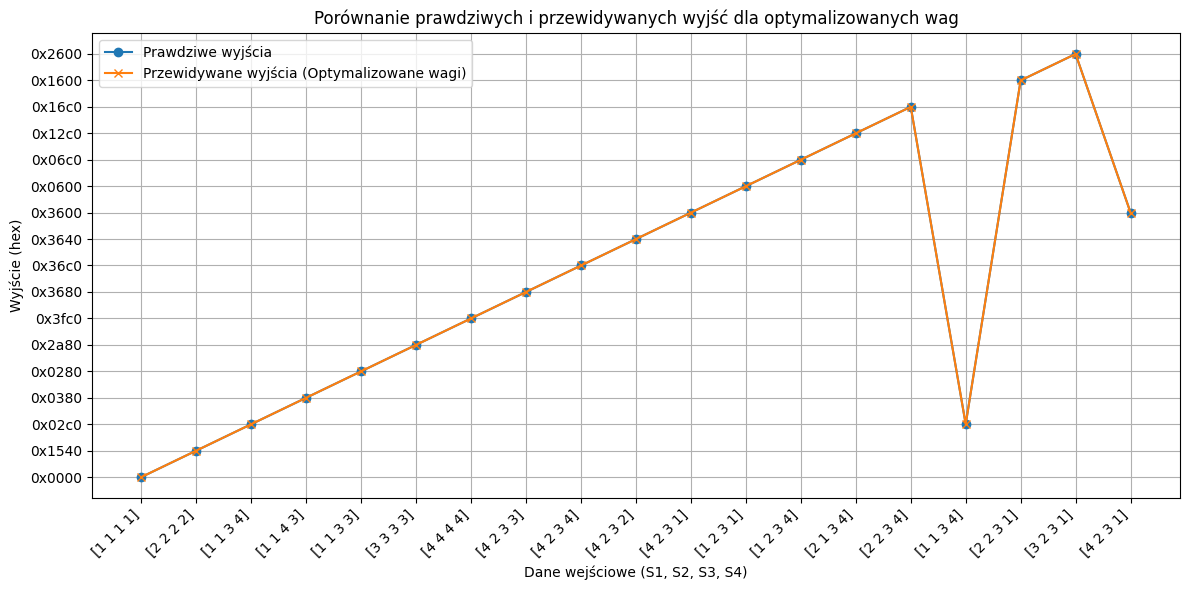

In [387]:
# 7. Test with new weights
optimized_model = generate_function(*optimized_weights)
predicted_outputs = np.array([optimized_model(*row) for row in X_test.values])
mae = mean_absolute_error(y_test, predicted_outputs)
print(f"Średni błąd absolutny dla optymalizowanych wag: {mae:.4f}")

# 8.1 Generate model
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = np.array([optimized_model(*row) for row in all_inputs])
print(f"Średni błąd absolutny dla optymalizowanych wag (całość): {mae:.4f}")


# 8.2 Plot
x_labels = [f"{row}" for row in X.values]
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y)),
    [f"{int(val):#06x}" for val in y.values],
    label="Prawdziwe wyjścia",
    marker="o",
)
plt.plot(
    range(len(all_predicted_outputs)),
    [f"{int(val):#06x}" for val in all_predicted_outputs],
    label="Przewidywane wyjścia (Optymalizowane wagi)",
    marker="x",
)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha="right")
plt.title("Porównanie prawdziwych i przewidywanych wyjść dla optymalizowanych wag")
plt.xlabel("Dane wejściowe (S1, S2, S3, S4)")
plt.ylabel("Wyjście (hex)")
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

In [380]:
from math import log


def ln(n) -> int:
    try:
        return log(n, 2)
    except:
        return -1


vl = np.vectorize(ln)

combined_df = pd.DataFrame(
    {
        "S1": X.values[:, 0],
        "S2": X.values[:, 1],
        "S3": X.values[:, 2],
        "S4": X.values[:, 3],
        "Prawdziwe wyjścia": y.values,
        "Prawdziwe wyjścia bin ": [f"{val:017_b}" for val in y.values],
        "Przewidywane wyjścia": all_predicted_outputs,
        "Error": (all_predicted_outputs - y.values),
        # "Error here": (
        #     0
        #     + X.values[:, 0] * (2 << 11)
        #     - X.values[:, 1] * (2 << 8)
        #     - X.values[:, 2] * (2 << 8)
        #     - ((X.values[:, 3] - 1) * (-2 << 5))
        # )
        # - y.values,
    }
)

combined_df

,S1,S2,S3,S4,Prawdziwe wyjścia,Prawdziwe wyjścia bin,Przewidywane wyjścia,Error
0,1,1,1,1,0,00_0000_0000_0000,0,0
1,2,2,2,2,5440,01_0101_0100_0000,5440,0
2,1,1,3,4,704,00_0010_1100_0000,704,0
3,1,1,4,3,896,00_0011_1000_0000,896,0
4,1,1,3,3,640,00_0010_1000_0000,640,0
5,3,3,3,3,10880,10_1010_1000_0000,10880,0
6,4,4,4,4,16320,11_1111_1100_0000,16320,0
7,4,2,3,3,13952,11_0110_1000_0000,13952,0
8,4,2,3,4,14016,11_0110_1100_0000,14016,0
9,4,2,3,2,13888,11_0110_0100_0000,13888,0


In [258]:
print(bin((1 << 4) - 1))

0b1111


   Prawdziwe wyjścia hex  S1  bit 12  S2  bit 08  S3  bit 04  S4  bit 00
0                 0x0000   1       0   1       0   1       0   1       0
1                 0x1540   2       1   2       5   2       5   2       4
2                 0x3600   4       3   2       6   3       8   1       0
3                 0x0600   1       0   2       6   3       8   1       0
4                 0x1600   2       1   2       6   3       8   1       0
5                 0x2600   3       2   2       6   3       8   1       0
6                 0x3600   4       3   2       6   3       8   1       0
7                 0x3640   4       3   2       6   3       9   2       4
8                 0x0280   1       0   1       2   3      10   3       8
9                 0x2a80   3       2   3      10   3      10   3       8
10                0x3680   4       3   2       6   3      10   3       8
11                0x02c0   1       0   1       2   3      11   4      12
12                0x36c0   4       3   2       6   

<Axes: >

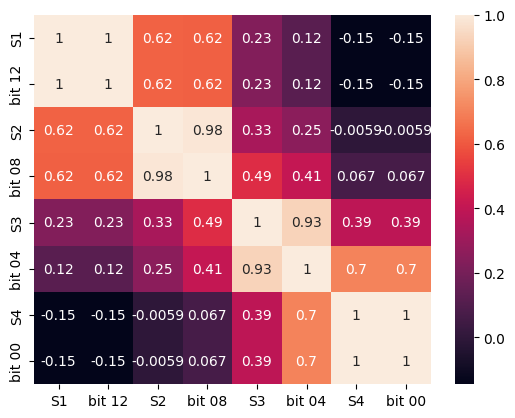

In [385]:
import seaborn as sns

width = 4
mask = (1 << width) - 1

combined_df = pd.DataFrame(
    {
        "Prawdziwe wyjścia hex": [f"{val:#06x}" for val in y.values],
        "S1": X.values[:, 0],
        "bit 12": ((y.values >> 12) & mask),  # ok
        "S2": X.values[:, 1],
        "bit 08": ((y.values >> 8) & mask),  # ok
        "S3": X.values[:, 2],
        "bit 04": ((y.values >> 6) & mask),
        "S4": X.values[:, 3],
        "bit 00": ((y.values >> 4) & mask),  # ok
        # "Prawdziwe wyjścia bin": [f"{val:019_b}" for val in y.values],
        # "Przewidywane wyjścia bin": [f"{val:019_b}" for val in all_predicted_outputs],
        # "Error": [f"{val:019_b}" for val in (all_predicted_outputs ^ y.values)],
        # "Przewidywane wyjścia": all_predicted_outputs,
        # "Error": (all_predicted_outputs - y.values) / X.values[:, 3],
        # "Error here": (
        #     0
        #     + X.values[:, 0] * (2 << 11)
        #     - X.values[:, 1] * (2 << 8)
        #     - X.values[:, 2] * (2 << 8)
        #     - X.values[:, 3] * (2 << 8)
        # )
        # - y.values,
    }
)
# combined_df.sort_values(["Prawdziwe wyjścia bin"], ignore_index=True, inplace=True)
combined_df.sort_values(["bit 04", "S3"], ignore_index=True, inplace=True)
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    print(combined_df)
    print("")
sns.heatmap(combined_df.corr(numeric_only=True), annot=True)

In [124]:
bin(10944)

'0b10101011000000'

## Visuals


In [ ]:
# 9. Opcjonalne: Wizualizacja wyników
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel("Rzeczywiste wyjścia")
plt.ylabel("Przewidywane wyjścia")
plt.title("Porównanie rzeczywistych i przewidywanych wyjść")
plt.show()

In [ ]:
# 8. Eksport wyników i interpretacja
# Wyniki mogą zostać zapisane do pliku CSV dla dalszej analizy
df_results = pd.DataFrame({"Actual": y_test, "Predicted": np.round(predictions)})
df_results
# df_results.to_csv("results.csv", index=False)

In [97]:
bin(0x1F)

'0b11111'

# Test output function


In [ ]:
# 7. Tworzenie funkcji predykcyjnej
def predict_output_model(S2, S3, S4):
    input_data = np.array([[S2, S3, S4]])
    output = model.predict(input_data)
    return int(output[0])  # Konwersja wyniku na liczbę całkowitą


predict_output = predict_output_model

# 8. Testowanie funkcji generującej na wszystkich inputach i wizualizacja
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = [predict_output(*row) for row in all_inputs]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(all_true_outputs, label="Prawdziwe wyjścia", marker="o")
plt.plot(all_predicted_outputs, label="Przewidywane wyjścia", marker="x")
plt.title("Porównanie prawdziwych i przewidywanych wyjść")
plt.xlabel("Przykład")
plt.ylabel("Wyjście")
plt.legend()
plt.grid()
plt.show()